In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import glob
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import time
import cv2
from sklearn.model_selection import train_test_split
import gc
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation,Dropout,BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train', 'test', 'sample_submission.csv']


In [2]:
data = '../input/'
train_files = sorted(glob.glob(data + 'train/*/*'))
# test_path = sorted(glob.glob(data + 'test/*'))

labels = ['HTC-1-M7', 'iPhone-4s', 'iPhone-6', 'LG-Nexus-5x', 'Motorola-Droid-Maxx', 
         'Motorola-Nexus-6', 'Motorola-X', 'Samsung-Galaxy-Note3', 'Samsung-Galaxy-S4',
         'Sony-NEX-7'] 
All_labels = [labels.index(file.split('/')[-2]) for file in train_files] # TO BE CHANGED!!!!!!!

x_train_files, x_test_files, y_train_files, y_test_files = train_test_split(train_files,All_labels,test_size = 0.2, shuffle = True,random_state = 42)

# y_train = keras.utils.to_categorical(y_train_files, len(labels)) # one hot vector
y_test = keras.utils.to_categorical(y_test_files, len(labels)) # one hot vector

In [3]:
# y_train_files
len(y_train_files)

2200

In [4]:
crdim = 256

kernel_filter = 1/12. * np.array([\
            [-1,  2,  -2,  2, -1],  \
            [ 2, -6,   8, -6,  2],  \
            [-2,  8, -12,  8, -2],  \
            [ 2, -6,   8, -6,  2],  \
            [-1,  2,  -2,  2, -1]])






train_imgs = []
count_file = -1
y_augm = [] # augmented labels
for file in tqdm_notebook(x_train_files):
    img = cv2.imread(file)
    x,y = img.shape[:2]

    count_file += 1 # number of img out of 2750 (or len of train set)
    img_label = y_train_files[count_file]    
    

    x,y = img.shape[:2]

    xpos = []
#     xpos.append([0,crdim])
    xpos.append([x//2-crdim//2,x//2+crdim//2])
#     xpos.append([x-crdim,x])

    ypos = []
#     ypos.append([0,crdim])
    ypos.append([y//2-crdim//2,y//2+crdim//2])
    ypos.append([y//2,y//2+crdim])
#     ypos.append([y-crdim,y])

    cr_imgs = []
    for i in xpos:
        for j in ypos:
            crimg = img[i[0]:i[1], j[0]:j[1],:]
#             crimg = cv2.filter2D(crimg.astype(np.float32),-1,kernel_filter)
            crimg = crimg.astype(np.float32)
            train_imgs.append(crimg)
            
    for t in range(len(xpos)*len(ypos)): # total crops
        y_augm.append(y_train_files[count_file]) # augment labels

            
    del file,img,crimg
    gc.collect()

train_imgs = np.array(train_imgs)

In [5]:
dim = 256

kernel_filter = 1/12. * np.array([\
            [-1,  2,  -2,  2, -1],  \
            [ 2, -6,   8, -6,  2],  \
            [-2,  8, -12,  8, -2],  \
            [ 2, -6,   8, -6,  2],  \
            [-1,  2,  -2,  2, -1]])


test_imgs = []
for file in tqdm_notebook(x_test_files):
    img = cv2.imread(file)
    center_x = img.shape[0]//2
    center_y = img.shape[1]//2 
    cropped_img = img[center_x-dim//2:center_x+dim//2, center_y-dim//2:center_y+dim//2, : ]
    
    cropped_img = cv2.filter2D(cropped_img.astype(np.float32),-1,kernel_filter)    
    test_imgs.append(cropped_img)
    del file,img,center_x,center_y,cropped_img
    gc.collect()

test_imgs = np.array(test_imgs)

In [6]:
y_train = keras.utils.to_categorical(y_augm, len(labels)) # one hot vector

In [7]:
def myFunc(img):
    kernel_filter = 1/12. * np.array([\
            [-1,  2,  -2,  2, -1],  \
            [ 2, -6,   8, -6,  2],  \
            [-2,  8, -12,  8, -2],  \
            [ 2, -6,   8, -6,  2],  \
            [-1,  2,  -2,  2, -1]])

    pro_img = cv2.filter2D(img,-1,kernel_filter)
    return pro_img

In [8]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip = True,preprocessing_function = myFunc)
# datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip = True)
datagen.fit(train_imgs)

In [9]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
#     lr = 0.0001
#     if epoch > 180:
#         lr *= 0.5e-3
#     elif epoch > 160:
#         lr *= 1e-3
#     elif epoch > 120:
#         lr *= 1e-2
#     elif epoch > 80:
#         lr *= 1e-1
#     print('Learning rate: ', lr)
#     return lr

    lr = 0.0001
    if epoch > 100:
        lr *= 1e-3
    elif epoch > 80:
        lr = lr/100
    elif epoch > 40:
        lr = lr/10
    elif epoch > 5:
        lr = lr
    elif epoch > -1:
        lr = lr*2
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

In [10]:
model=Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),strides=(2, 2), input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size=(3, 3),strides=(2, 2) ))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(10))
model.add(Activation('softmax'))

# opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = keras.optimizers.rmsprop(lr=lr_schedule(0), decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Learning rate:  0.0002
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 127, 127, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 127, 127, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 63, 63, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 32)      

In [11]:
mlp_hist = model.fit_generator(datagen.flow(train_imgs, y_train, batch_size=32), validation_data=(test_imgs,y_test) ,steps_per_epoch= None, epochs=80, callbacks=callbacks) 

Epoch 1/80
Learning rate:  0.0002
138/138 [==============================] - 19s 135ms/step - loss: 2.5066 - acc: 0.1721 - val_loss: 1.9790 - val_acc: 0.2618
Epoch 2/80
Learning rate:  0.0002
138/138 [==============================] - 16s 114ms/step - loss: 1.9761 - acc: 0.2516 - val_loss: 1.6960 - val_acc: 0.3727
Epoch 3/80
Learning rate:  0.0002
138/138 [==============================] - 16s 115ms/step - loss: 1.7914 - acc: 0.3204 - val_loss: 1.7128 - val_acc: 0.3655
Epoch 4/80
Learning rate:  0.0002
138/138 [==============================] - 16s 114ms/step - loss: 1.6876 - acc: 0.3689 - val_loss: 1.4783 - val_acc: 0.4255
Epoch 5/80
Learning rate:  0.0002
138/138 [==============================] - 16s 115ms/step - loss: 1.6036 - acc: 0.3940 - val_loss: 1.6048 - val_acc: 0.3727
Epoch 6/80
Learning rate:  0.0002
138/138 [==============================] - 16s 114ms/step - loss: 1.5421 - acc: 0.4346 - val_loss: 1.4086 - val_acc: 0.4345
Epoch 7/80
Learning rate:  0.0001
138/138 [=========

In [12]:
# del model
# gc.collect()

In [13]:
scores = model.evaluate(test_imgs,y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

550/550 [==============================] - 1s 2ms/step
Test loss: 0.621182821338827
Test accuracy: 0.8054545452378012


In [14]:
# del train_imgs
# del test_imgs
# gc.collect()

In [15]:
epochs = 80

No handles with labels found to put in legend.


Text(0,0.5,'Accuracy')

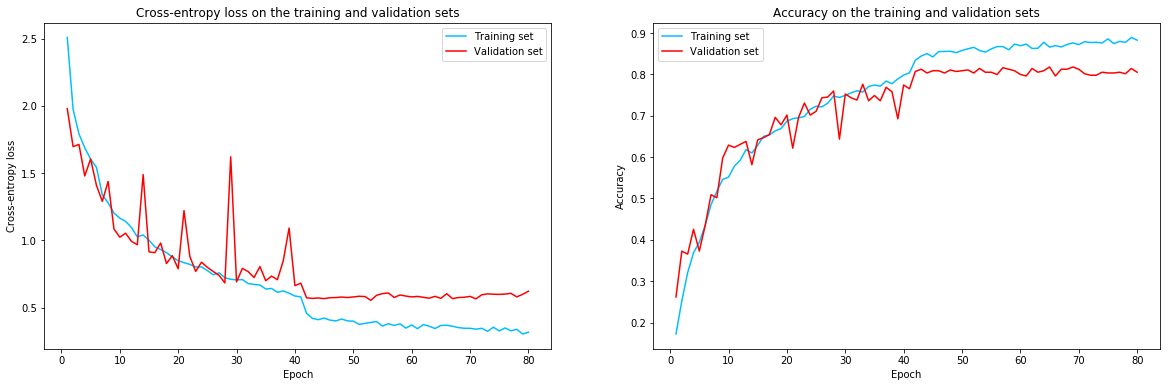

In [16]:
plt.rcParams["figure.figsize"] = (20,6)
plt.subplot(1, 2, 1)
plt.plot(range(1,epochs+1), mlp_hist.history['loss'], c='deepskyblue')
plt.plot(range(1,epochs+1), mlp_hist.history['val_loss'], c='red')
plt.legend(['Training set','Validation set'])
plt.title('Cross-entropy loss on the training and validation sets')
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy loss')
plt.subplot(1, 2, 2)
plt.plot(range(1,epochs+1), mlp_hist.history['acc'], c='deepskyblue')
plt.plot(range(1,epochs+1), mlp_hist.history['val_acc'], c='red')
plt.legend(loc='lower right')
plt.legend(['Training set','Validation set'])
plt.title('Accuracy on the training and validation sets')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [17]:
model.save("SmallNetWeights.h5")

In [18]:
# mlp.load_weights("../input/simple-neural-network/SmallNetWeights.h5")